<a href="https://colab.research.google.com/github/Rohithtechis/Kaggle_HL_classification/blob/main/Handwritten_Letter_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np 
import pandas as pd
import os
print(os.listdir('/content/input'))


['letters3.csv', 'LetterColorImages2.h5', 'letters2.csv', 'letters.csv', 'LetterColorImages3.h5', 'letters2.txt', 'letters3.txt', 'LetterColorImages.h5', 'LetterColorImages_123.h5']


In [30]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

data1 = pd.read_csv("/content/input/letters.csv")
files1 = data1['file']
letters1 = data1['letter']
backgrounds1 = data1['background']

data2 = pd.read_csv("/content/input/letters2.csv")
files2 = data2['file']
letters2 = data2['letter']
backgrounds2 = data2['background']

data3 = pd.read_csv("/content/input/letters3.csv")
files3 = data3['file']
letters3 = data3['letter']
backgrounds3 = data3['background']
data3.head()

,letter,label,file,background
0,а,1,01_231.png,3
1,а,1,01_232.png,3
2,а,1,01_233.png,3
3,а,1,01_234.png,3
4,а,1,01_235.png,3


In [26]:
f = h5py.File('/content/input/LetterColorImages_123.h5', 'r')
# List all groups
keys = list(f.keys())
keys 

['backgrounds', 'images', 'labels']

In [27]:
backgrounds = np.array(f[keys[0]])
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (14190, 32, 32, 3)
Target shape (14190,)
Background shape: (14190,)


In [31]:
letters = pd.concat((letters1, letters2), axis=0, ignore_index=True)
letters = pd.concat((letters, letters3), axis=0, ignore_index=True)
len(letters)

14190

In [32]:
tensors = tensors.astype('float32')/255

Label:  а


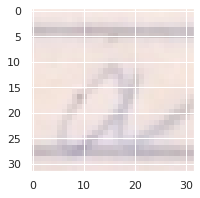

In [33]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

# Read and display a tensor using Matplotlib
print('Label: ', letters[10])
plt.figure(figsize=(3,3))
plt.imshow(tensors[10]);

In [34]:
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [35]:
from keras.utils import to_categorical

# One-hot encoding the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(14190, 33)

In [36]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

# Print the shape
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((11352, 32, 32, 3),
 (11352, 33),
 (1419, 32, 32, 3),
 (1419, 33),
 (1419, 32, 32, 3),
 (1419, 33))

In [37]:
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model = Sequential()

# Define a model architecture    
model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(LeakyReLU(alpha=0.02))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(196, (5, 5)))
model.add(LeakyReLU(alpha=0.02))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPooling2D())

model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.02))
model.add(Dropout(0.5)) 

model.add(Dense(33))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=[categorical_accuracy, top_3_categorical_accuracy])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [38]:
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.75)
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=50, batch_size=512, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction])


Train on 11352 samples, validate on 1419 samples
Epoch 1/50
 - 49s - loss: 3.4957 - categorical_accuracy: 0.0300 - top_3_categorical_accuracy: 0.0910 - val_loss: 3.4900 - val_categorical_accuracy: 0.0268 - val_top_3_categorical_accuracy: 0.0923

Epoch 00001: val_loss improved from inf to 3.49004, saving model to weights.best.model.hdf5
Epoch 2/50
 - 48s - loss: 3.4774 - categorical_accuracy: 0.0345 - top_3_categorical_accuracy: 0.1082 - val_loss: 3.4573 - val_categorical_accuracy: 0.0521 - val_top_3_categorical_accuracy: 0.1557

Epoch 00002: val_loss improved from 3.49004 to 3.45727, saving model to weights.best.model.hdf5
Epoch 3/50
 - 48s - loss: 3.4028 - categorical_accuracy: 0.0564 - top_3_categorical_accuracy: 0.1579 - val_loss: 3.3628 - val_categorical_accuracy: 0.0712 - val_top_3_categorical_accuracy: 0.1860

Epoch 00003: val_loss improved from 3.45727 to 3.36276, saving model to weights.best.model.hdf5
Epoch 4/50
 - 48s - loss: 3.3261 - categorical_accuracy: 0.0682 - top_3_cat

In [40]:
y_test_predict = model.predict_classes(x_test)

In [46]:
score = model.evaluate(x_test, y_test)
score

1419/1419 [==============================] - 2s 1ms/step


[0.6391378811037481, 0.8280479311943054, 0.9400986433029175]

In [43]:
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

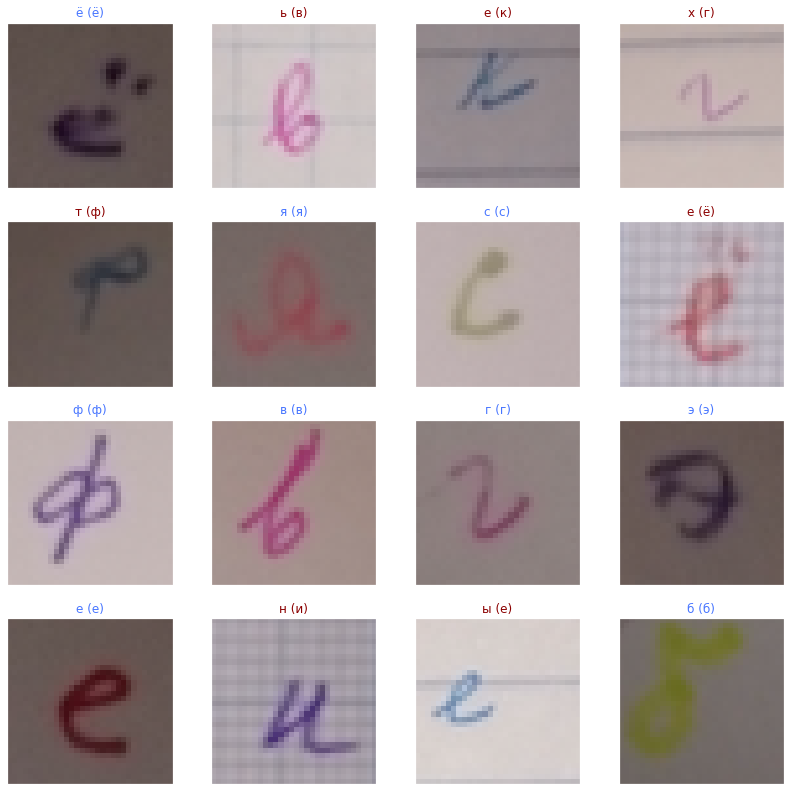

In [44]:
fig = plt.figure(figsize=(14, 14))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))